# 01 - Sentence Classification Model Building


# Parse & clearn labeled training data

In [2]:
import xml.etree.ElementTree as ET
tree = ET.parse('Restaurants_Train.xml')
root = tree.getroot()
import pandas as pd
from keras.models import load_model
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,GRU,CuDNNGRU,RNN,CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D,Input, SpatialDropout1D, add, concatenate,GlobalMaxPool1D
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam,RMSprop,SGD,Adagrad,Adamax
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import matplotlib as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import string
import numpy as np
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from nltk.corpus import stopwords,wordnet as wn
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from  sklearn.preprocessing import StandardScaler
import re
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
%matplotlib inline
np.random.seed(2)
'done'

Using TensorFlow backend.


'done'

In [3]:


labeled_reviews = []
for sentence in root.findall("sentence"):
    entry = {}
    aterms = []
    aspects = []
    if sentence.find("aspectTerms"):
        for aterm in sentence.find("aspectTerms").findall("aspectTerm"):
            aterms.append(aterm.get("term"))
    if sentence.find("aspectCategories"):
        for aspect in sentence.find("aspectCategories").findall("aspectCategory"):
            aspects.append(aspect.get("category"))
    entry["text"], entry["terms"], entry["aspects"]= sentence[0].text, aterms, aspects
    labeled_reviews.append(entry)
labeled_df = pd.DataFrame(labeled_reviews)
print("there are",len(labeled_reviews),"reviews in this training set")
#    print(sentence.find("aspectCategories").findall("aspectCategory").get("category"))

there are 3044 reviews in this training set


In [4]:

labeled_df.to_pickle("annotated_reviews_df.pkl")
labeled_df.head(200)

,text,terms,aspects
0,But the staff was so horrible to us.,[staff],[service]
1,"To be completely fair, the only redeeming fact...",[food],"[food, anecdotes/miscellaneous]"
2,"The food is uniformly exceptional, with a very...","[food, kitchen, menu]",[food]
3,Where Gabriela personaly greets you and recomm...,[],[service]
4,"For those that go once and don't enjoy it, all...",[],[anecdotes/miscellaneous]
...,...,...,...
195,The fish is fresh but the variety of fish is n...,"[fish, variety of fish]",[food]
196,Look I dont know if the people who wrote the r...,[],[anecdotes/miscellaneous]
197,Suan has challenged this loyalty.,[],[anecdotes/miscellaneous]
198,"Our favorite meal is a pesto pizza, the house ...","[pesto pizza, house salad, bottle of wine, meal]",[food]


# Training the model with Naive Bayes
1. replace pronouns with neural coref
2. train the model with naive bayes

In [5]:

annotated_reviews_df = pd.read_pickle("annotated_reviews_df.pkl")
annotated_reviews_df.head(200)


,text,terms,aspects
0,But the staff was so horrible to us.,[staff],[service]
1,"To be completely fair, the only redeeming fact...",[food],"[food, anecdotes/miscellaneous]"
2,"The food is uniformly exceptional, with a very...","[food, kitchen, menu]",[food]
3,Where Gabriela personaly greets you and recomm...,[],[service]
4,"For those that go once and don't enjoy it, all...",[],[anecdotes/miscellaneous]
...,...,...,...
195,The fish is fresh but the variety of fish is n...,"[fish, variety of fish]",[food]
196,Look I dont know if the people who wrote the r...,[],[anecdotes/miscellaneous]
197,Suan has challenged this loyalty.,[],[anecdotes/miscellaneous]
198,"Our favorite meal is a pesto pizza, the house ...","[pesto pizza, house salad, bottle of wine, meal]",[food]


In [6]:
# nltk.download('stopwords')



contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
contraction_mapping


{"ain't": 'is not',
 "aren't": 'are not',
 "can't": 'cannot',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he would',
 "he'll": 'he will',
 "he's": 'he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how is',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I've": 'I have',
 "i'd": 'i would',
 "i'd've": 'i would have',
 "i'll": 'i will',
 "i'll've": 'i will have',
 "i'm": 'i am',
 "i've": 'i have',
 "isn't": 'is not',
 "it'd": 'it would',
 "it'd've": 'it would have',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'madam',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": 'must have',
 "mustn't": 'm

In [7]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [8]:
# nltk.download('wordnet')
def text_process(text):
    text = text.translate(string.punctuation)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    text = " ".join(text)
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    stemmed_words = [lemmatizer.lemmatize(word,pos='v') for word in text]
    text = " ".join(stemmed_words)
    return text


In [10]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(annotated_reviews_df.aspects)
X = annotated_reviews_df.text

In [11]:
X_train, tetum, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [12]:
tetum

453     It's better than being on the roof of Sutton P...
1611    Don't expect to sit down inside though, there ...
2078    Again, if you are in this neighborhood - by al...
2715    Go there to relax and feel like your somewhere...
2602    As far as the service goes, the waitresses wer...
                              ...                        
768               i dont how this place is still running.
2652    The waiters and owners were nonchalant about t...
346     It melted in my little mouth and the perfect c...
1418              One of my favorite places in Manhattan.
141     The lava cake dessert was incredible and I rec...
Name: text, Length: 609, dtype: object

In [13]:


annotated_reviews_df['text'] = annotated_reviews_df['text'].map(lambda x: clean_contractions(x,contraction_mapping))

annotated_reviews_df['text'] = annotated_reviews_df['text'].map(lambda x: text_process(x))
annotated_reviews_df['text']

0                                       staff horrible us
1       completely fair redeem factor food average cou...
2       food uniformly exceptional capable kitchen pro...
3                  gabriela personaly greet recommend eat
4                                     enjoy it say get it
                              ...                        
3039                                    highly forgivable
3040    appetizers eat dim sum variety foods impossibl...
3041        arrive 6 : 00 pm restaurant practically empty
3042    table pot boil water sink surface get platters...
3043                            go mid town location next
Name: text, Length: 3044, dtype: object

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import pickle
# Convert the multi-labels into arrays
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(annotated_reviews_df.aspects)
X = annotated_reviews_df.text

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

filename = 'mlb.pkl'
pickle.dump(mlb, open(filename, 'wb'))
print('done')

done


In [15]:
X_train.shape,X_test.shape

((2435,), (609,))

In [16]:
y_test

array([[0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [17]:
mlb_labels=pd.read_pickle('mlb.pkl')
mlb_labels

MultiLabelBinarizer(classes=None, sparse_output=False)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import LabelPowerset
import numpy as np

text_clf = Pipeline([('vect',  CountVectorizer(stop_words = "english",ngram_range=(1, 1))),
                     ('tfidf', TfidfTransformer(use_idf=False)),
                     ('clf',   LabelPowerset(MultinomialNB(alpha=1e-1))),])
text_clf = text_clf.fit(X_train,  y_train)
predicted = text_clf.predict(X_test)
# print(predicted[50])
# Calculate accuracy
np.mean(predicted == y_test)

0.8673234811165845

In [19]:
print(predicted)

  (0, 1)	1
  (1, 4)	1
  (2, 1)	1
  (3, 0)	1
  (4, 4)	1
  (5, 2)	1
  (6, 0)	1
  (7, 4)	1
  (8, 2)	1
  (9, 1)	1
  (10, 2)	1
  (11, 2)	1
  (11, 3)	1
  (12, 1)	1
  (13, 0)	1
  (14, 4)	1
  (15, 1)	1
  (16, 1)	1
  (17, 1)	1
  (18, 1)	1
  (19, 2)	1
  (20, 2)	1
  (21, 1)	1
  (22, 1)	1
  (23, 1)	1
  (24, 4)	1
  (25, 2)	1
  (26, 1)	1
  (27, 1)	1
  (28, 2)	1
  (28, 3)	1
  (29, 4)	1
  (30, 2)	1
  (31, 1)	1
  (32, 4)	1
  (33, 2)	1
  (34, 1)	1
  (35, 1)	1
  (36, 2)	1
  (37, 4)	1
  (38, 4)	1
  (39, 1)	1
  (40, 2)	1
  (41, 2)	1
  (41, 4)	1
  (42, 2)	1
  (43, 4)	1
  (44, 2)	1
  (45, 1)	1
  (46, 4)	1
  (47, 1)	1
  (48, 1)	1
  (49, 1)	1
  (50, 1)	1
  (51, 1)	1
  (52, 2)	1
  (53, 4)	1
  (54, 2)	1
  (54, 4)	1
  (55, 2)	1
  (56, 2)	1
  (57, 1)	1
  (58, 2)	1
  (59, 2)	1
  (60, 2)	1
  (61, 2)	1
  (62, 4)	1
  (63, 4)	1
  (64, 2)	1
  (65, 4)	1
  (66, 4)	1
  (67, 2)	1
  (68, 1)	1
  (69, 1)	1
  (70, 1)	1
  (71, 0)	1
  (72, 1)	1
  (73, 2)	1
  (74, 1)	1
  (75, 2)	1
  (76, 0)	1
  (76, 2)	1
  (76, 4)	1
  (77, 0)	1
  

In [20]:

from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', LabelPowerset(
                             SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, max_iter=6, random_state=42)))])
_ = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)

#Calculate accuracy
np.mean(predicted_svm == y_test)

0.864367816091954

In [21]:
X.shape

(3044,)

In [22]:
X_train.shape

(2435,)

In [23]:
import io
import json
vocab_size = 25000
embedding_dim = 16
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"



tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)
'done'


'done'

In [24]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i,'<UNK>') for i in text])#<UNK> in padded means it reached max dictionary size

print(decode_review(padded[11]))#this is the padded one with max 120 size of words
print(X_train[11])#original sentence

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> monthly basis friends get together girls night out
mayonnaise forget toast leave ingredients ie cheese omelet hot temperatures bacon cook crumble plate touch it


In [25]:
#gloove
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))


from keras.optimizers import Adam


# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

'loaded'

Loaded 400000 word vectors.


'loaded'

In [26]:
from keras.utils import plot_model
import matplotlib.pyplot as plt
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=100, weights=[embedding_matrix], trainable=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dense(5, activation='sigmoid')
])
opt=tf.keras.optimizers.Adam(learning_rate=0.00083,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
    )
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
tf.keras.metrics.AUC(),tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalsePositives()
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2500000   
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               132000    
_________________________________________________________________
dense (Dense)                (None, 5)                 1005      
Total params: 2,665,069
Trainable params: 2,665,069
Non-trainable params: 0
______________________________________________

In [27]:
num_epochs = 7
history= model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test))

Train on 2435 samples, validate on 609 samples
Epoch 1/7
2435/2435 [==============================] - 23s 10ms/sample - loss: 0.4852 - accuracy: 0.7890 - precision: 0.6541 - recall: 0.2860 - auc: 0.7343 - true_negatives: 8757.0000 - false_positives: 449.0000 - val_loss: 0.4014 - val_accuracy: 0.8378 - val_precision: 0.7436 - val_recall: 0.5114 - val_auc: 0.8332 - val_true_negatives: 2171.0000 - val_false_positives: 131.0000on: 0.6392 - recall: 0.2611 - auc: 0.7227 - true_negatives: 7844.0000 - false_positives:
Epoch 2/7
2435/2435 [==============================] - 7s 3ms/sample - loss: 0.3562 - accuracy: 0.8540 - precision: 0.7947 - recall: 0.5409 - auc: 0.8778 - true_negatives: 8791.0000 - false_positives: 415.0000 - val_loss: 0.3357 - val_accuracy: 0.8581 - val_precision: 0.7640 - val_recall: 0.6057 - val_auc: 0.8980 - val_true_negatives: 2163.0000 - val_false_positives: 139.0000
Epoch 3/7
2435/2435 [==============================] - 6s 3ms/sample - loss: 0.2792 - accuracy: 0.8863 - 

In [28]:
model.save('lstm_model_reviews_300d.h5')
'done'

'done'

In [29]:
model_save = tf.keras.models.load_model('lstm_model_reviews_300d.h5')
'loaded'

'loaded'

In [30]:
predictionss = model_save.predict(testing_padded)
print(predictionss)

[[5.6999503e-03 8.2151741e-01 2.1402623e-01 6.0940492e-03 3.6655192e-03]
 [4.9036711e-01 2.0586047e-01 2.1017701e-03 3.4555148e-03 6.3156271e-01]
 [1.4003474e-02 9.9144053e-01 7.3353125e-04 6.1239363e-03 7.9450570e-03]
 ...
 [3.3200076e-01 6.6264323e-03 9.7670275e-01 2.6214207e-02 2.6519412e-02]
 [6.4067226e-03 9.8645055e-01 2.4948665e-03 8.7024905e-03 2.0660630e-03]
 [3.7238360e-03 5.5966885e-03 9.9526137e-01 3.7246656e-02 4.7743350e-02]]


In [31]:
prediction = model.predict(testing_padded)
print(prediction)

[[5.6999503e-03 8.2151741e-01 2.1402623e-01 6.0940492e-03 3.6655192e-03]
 [4.9036711e-01 2.0586047e-01 2.1017701e-03 3.4555148e-03 6.3156271e-01]
 [1.4003474e-02 9.9144053e-01 7.3353125e-04 6.1239363e-03 7.9450570e-03]
 ...
 [3.3200076e-01 6.6264323e-03 9.7670275e-01 2.6214207e-02 2.6519412e-02]
 [6.4067226e-03 9.8645055e-01 2.4948665e-03 8.7024905e-03 2.0660630e-03]
 [3.7238360e-03 5.5966885e-03 9.9526137e-01 3.7246656e-02 4.7743350e-02]]


In [32]:
for i in range(len(prediction)):
    for j in range(len(prediction[i])):
        if prediction[i][j]>=0.5:
            prediction[i][j]=1
        else:
            prediction[i][j]=0
prediction

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

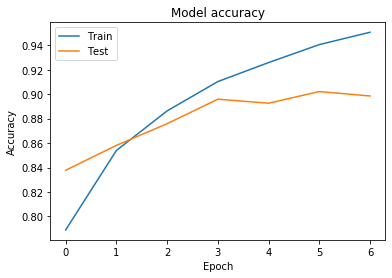

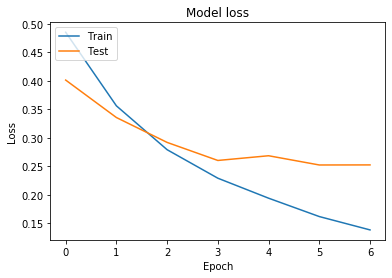

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [34]:
filename = 'lstm_model1.pkl'
# pickle.dump(history, open(filename, 'wb'))
# print('done')
e = model.layers[0]
weigh = e.get_weights()[0]
fpkl= open(filename, 'wb')       
pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
fpkl.close()
'done'

'done'

In [35]:
import pickle

text_clf = Pipeline([('vect', CountVectorizer(stop_words = "english",ngram_range=(1, 1))),
                     ('tfidf', TfidfTransformer(use_idf=False)),
                     ('clf', LabelPowerset(MultinomialNB(alpha=1e-1))),])
text_clf = text_clf.fit(X, y)


filename = 'naive_model1.pkl'
pickle.dump(text_clf, open(filename, 'wb'))
print('done')

done


In [36]:
#lstm
pred_df_lstm = pd.DataFrame(
    {'text_pro': tetum,
     'pred_category': mlb.inverse_transform(prediction)
    })
'done'

'done'

In [37]:
pd.set_option('display.max_colwidth', -1)
pred_df_lstm.head(30)

,text_pro,pred_category
453,It's better than being on the roof of Sutton Place with 19 year old interns jabbing you in the ribs all night.,"(anecdotes/miscellaneous,)"
1611,"Don't expect to sit down inside though, there are only a few tables and they are always full.","(service,)"
2078,"Again, if you are in this neighborhood - by all means, come here.","(anecdotes/miscellaneous,)"
2715,Go there to relax and feel like your somewhere else.,"(ambience, anecdotes/miscellaneous)"
2602,"As far as the service goes, the waitresses were not particularly friendly, but they got the job done.","(service,)"
2793,Just stick with the small dishes!,"(food,)"
2850,"The atmosphere is nothing special, but it feels like a Sushi establishment in Tokyo.","(ambience,)"
1184,"But when you are seated the waitresses are great, they explain everything on the menu, and the price of the food is really cheap for the service you get.","(food, price, service)"
2539,They had scrapped the bottom of the vessel in which they make the rice -RESULT - WE HAD LARGE CHUNKS OF BURNT RICE IN OUR SERVING BOWL.,"(food,)"
2266,"It is nearly impossible to get a table, so if you ever have the chance to go here for dinner, DO NOT pass it up.","(anecdotes/miscellaneous,)"


In [38]:

pred_df = pd.DataFrame(
    {'text_pro': X_test,
     'pred_category': mlb.inverse_transform(predicted)
    })
'done'

'done'

In [39]:
pd.set_option('display.max_colwidth', -1)
pred_df.head(30)

,text_pro,pred_category
453,better roof sutton place year old intern jab rib night,"(anecdotes/miscellaneous,)"
1611,expect sit inside though table always full,"(service,)"
2078,again neighborhood mean come here,"(anecdotes/miscellaneous,)"
2715,relax feel like somewhere else,"(ambience,)"
2602,far service go waitress particularly friendly get job do,"(service,)"
2793,stick small dish !,"(food,)"
2850,atmosphere nothing special feel like sushi establishment tokyo,"(ambience,)"
1184,seat waitress great explain everything menu price food really cheap service get,"(service,)"
2539,scrap bottom vessel make rice - result large chunk burn rice serve bowl,"(food,)"
2266,nearly impossible get table ever chance dinner pass up,"(anecdotes/miscellaneous,)"
